In [11]:
import json
import re
import requests
from datetime import datetime
import sqlite3
base_params = {'access_token': '',
              'v': '5.95', 'owner_id': '-156444315'}
# svtvofficial: -156444315
# cooktech: -170569428

In [12]:
def vk(method, params):
    api_req = 'https://api.vk.com/method/'
    api_req += method + '?'
    api_req += '&'.join(['{}={}'.format(key, params[key]) for key in params])
    json_raw = requests.get(api_req).text
    return json.loads(json_raw)

In [13]:
def humandate(udate):
    date = datetime.fromtimestamp(udate).strftime('%Y-%m-%d %H:%M:%S')
    return date

In [14]:
def wall_dl(base_params):
    m = 'wall.get'
    res = vk(m, base_params)
    #print(res)
    post_amount = res["response"]["count"]
    params = base_params.copy()
    i = 0
    posts = {}
    while i < post_amount:
        params['offset'] = str(i)
        if post_amount - i >= 100:
            count = 100
        else:
            count = post_amount - i
        params['count'] = str(count)
        result = vk(m, params)
        for j in range(count):
            items = result['response']['items'][j]
            text = items["text"]
            post_id = items["id"]
            date_unix = items['date']
            date = humandate(date_unix)
            text = re.sub('\n', ' ', text)
            likes = items['likes']['count']
            posts[post_id] = [text, date, likes]
        i += 100
    return posts

In [15]:
def get_the_age(bdate):
    td_str = str(datetime.today())
    td_list = td_str[:10].split('-')
    td = [int(td_list[2]), int(td_list[1]), int(td_list[0])]
    bd_list = bdate.split('.')
    bd = [int(bd_list[0]), int(bd_list[1]), int(bd_list[2])]
    if bd[1] > td[1]:
        age = td[2] - bd[2] - 1
    elif bd[1] < td[1]:
        age = td[2] - bd[2]
    else:
        if bd[0] > td[0]:
            age = td[2] - bd[2] - 1
        elif bd[0] <= td[0]:
            age = td[2] - bd[2]
    return age

In [16]:
def snooping(base_params, user_id):
    params = base_params.copy()
    del params['owner_id']
    params['user_id'] = user_id
    params['fields'] = 'city,sex,bdate'
    m = 'users.get'
    u_info = vk(m, params)
    if 'response' in u_info:
        info = u_info['response'][0]
        if 'sex' in info:
            if info['sex'] == 1:
                sex = 'f'
            elif info['sex'] == 2:
                sex = 'm'
            else:
                sex = ''
        if 'city' in info:
            city = info['city']['title']
        else:
            city = ''
        if 'bdate' in info and info['bdate'].count('.') == 2:
            age = get_the_age(info['bdate'])
        else:
            age = 0
    else:
        sex = ''
        city = ''
        age = ''
    return [sex, city, age]

In [17]:
def comments_dl(base_params, posts):
    m = 'wall.getComments'
    params = base_params.copy()
    #w=wall-170569428_
    for post_id in posts.keys():
        post_text = posts[post_id][0]
        comments = {}
        params['post_id'] = post_id
        res = vk(m, params)
        c_amount = len(res["response"]['items'])
        i = 0
        while i < c_amount:
            params['offset'] = str(i)
            if c_amount - i >= 100:
                count = 100
            else:
                count = c_amount - i
            params['count'] = c_amount
            result = vk(m, params)
            for j in range(count):
                com_wb = result['response']['items'][j]
                if 'text' in com_wb.keys():
                    text = com_wb['text']
                    text = re.sub('\n', ' ', text)
                    com_id = com_wb['id']
                    user_id = com_wb['from_id']
                    user_info = snooping(base_params, user_id)
                    com_list = [text, user_id]
                    com_list.extend(user_info)
                    comments[com_id] = com_list
            i += 100
        posts[post_id].append(comments)

In [18]:
def text_unlem(text):
    text = re.sub('[.,?!–—"]', ' ', text)
    repl = r'\1'
    text = re.sub('(\s)\s*', repl, text)
    words = text.split(' ')
    return words

In [39]:
def create_corpus(posts):
    conn = sqlite3.connect('svtv_corp.db')
    c = conn.cursor()
    c.execute("""
CREATE TABLE IF NOT EXISTS posts(id text primary key, post_text text,
date text, likes int)"""
              )
    c.execute("""
CREATE TABLE IF NOT EXISTS comments(comm_id text primary key, post_id text,
comment_text text, user_id text, sex text, city text, age int)"""
              )
    conn.commit()
    conn.close()
    conn = sqlite3.connect('svtv_corp.db')
    c = conn.cursor()
    for key in posts:
        p1 = key
        p2 = posts[key][0]
        p3 = posts[key][1]
        p4 = posts[key][2]
        row = (p1, p2, p3, p4)
        c.execute('INSERT INTO posts VALUES (?, ?, ?, ?)', row)
        conn.commit()
        com_dict = posts[key][3]
        for idc in com_dict:
            c2 = key
            c3 = com_dict[idc][0]
            c4 = com_dict[idc][1]
            c5 = com_dict[idc][2]
            c6 = com_dict[idc][3]
            c7 = com_dict[idc][4]
            crow = (idc, c2, c3, c4, c5, c6, c7)
            c.execute('INSERT INTO comments VALUES (?, ?, ?, ?, ?, ?, ?)', crow)
            conn.commit()
    conn.commit()
    conn.close()

In [41]:
def make_plain_unlem(posts):
    with open('svtv_unlem.txt', 'w', encoding='utf-16') as f:
        for key in posts:
            text = posts[key][0]
            f.write(text)
            f.write('\n')
            comments = posts[key][3]
            for cey in comments:
                cext = comments[cey][0]
                f.write(cext)
                f.write('\n')

In [50]:
def first_step(base_params):
    posts = wall_dl(base_params)
    comments_dl(base_params, posts)
    create_corpus(posts)
    make_plain_unlem(posts)
    
first_step(base_params)

In [51]:
def len_info(posts):
    len_dict = {}
    for post_id in posts:
        post_text = posts[post_id][0]
        post_len = len(text_unlem(post_text))
        coms = posts[post_id][3]
        count = len(coms)
        com_words = 0
        if count > 0:
            for com_id in coms:
                com_text = coms[com_id][0]
                w_in_com = text_unlem(com_text)
                com_words += len(w_in_com)
            av_com_len = round(com_words / count, 2)
        else:
            av_com_len = 0
        len_dict[post_id] = [post_len, av_com_len]
    return len_dict

In [134]:
def normalize_len(len_dict):
    new_dict = {}
    for key in len_dict:
        x = len_dict[key][0]
        y = len_dict[key][1]
        if x not in new_dict:
            new_dict[x] = [y]
        else:
            new_dict[x].append(y)
    for x_cord in new_dict:
        y_cords = new_dict[x_cord]
        if len(y_cords) == 1:
            new_dict[x_cord] = y_cords[0]
        else:
            y_av = round(sum(y_cords) / len(y_cords), 2)
            new_dict[x_cord] = y_av
    return new_dict

#nor_dict = normalize_len(len_dict)

In [135]:
import matplotlib.pyplot as plt
from matplotlib import style
from numpy import polyfit
import numpy as np 
from scipy.interpolate import interp1d
def graph_len(len_dict):
    x_post = []
    y_com = []
    for key in sorted(len_dict):
        x_post.append(key)
        y_com.append(len_dict[key])    
    return x_post, y_com

In [187]:
def make_graph(x, y, xname, yname, gtitle):
    coefficients = polyfit(x, y, 4)
    p = np.poly1d(coefficients) 
    x_p = np.linspace(0, max(x), 1000) 
    style.use('dark_background')
    plt.plot(x_p, p(x_p), c='red') 
    plt.title(gtitle) 
    plt.scatter(x, y)
    plt.xlabel(xname)
    plt.ylabel(yname)
    filename = gtitle + '.png'
    plt.savefig(filename, dpi=300)
    plt.show()

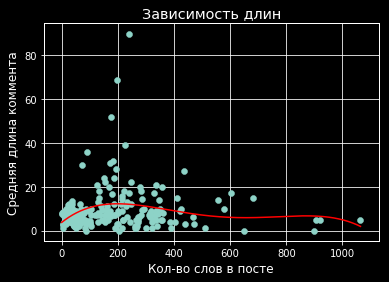

In [188]:
def graph1(posts):
    len_dict = len_info(posts)
    nor_dict = normalize_len(len_dict)
    x, y = graph_len(nor_dict)
    ttl = 'Зависимость длин'
    xl = 'Кол-во слов в посте'
    yl = 'Средняя длина коммента'
    make_graph(x, y, xl, yl, ttl)
    return len_dict
    
len_dict = graph1(posts)

In [189]:
def likes_per_length(posts, len_dict):
    lik_dict = {}
    for key in posts:
        likes = int(posts[key][2])
        post_len = len_dict[key][0]
        lik_dict[post_len] = likes
    x = []
    y = []
    for plen in sorted(lik_dict.keys()):
        x.append(plen)
        y.append(lik_dict[plen])
    return x, y

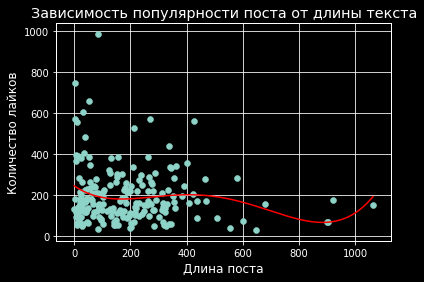

In [190]:
def graph2(posts, len_dict):
    x, y = likes_per_length(posts, len_dict)
    xl = 'Длина поста'
    yl = "Количество лайков"
    ttl = "Зависимость популярности поста от длины текста"
    make_graph(x, y, xl, yl, ttl)

graph2(posts, len_dict)

Прямой зависимости как бы и нет; но ввиду того, что паблик изначально был посвящен видео-контенту, максимальное количество лайков может быть у постов без текста (то есть состоящих из одного видео)

In [191]:
def comlen_per_city(posts):
    city_dict = {}
    for key in posts:
        coms = posts[key][3]
        for idc in coms:
            if coms[idc][3] != '':
                text = coms[idc][0]
                com_len = len(text_unlem(text))
                city = coms[idc][3]
                if city not in city_dict:
                    city_dict[city] = [com_len]
                else:
                    city_dict[city].append(com_len)
    new_dict = {}
    for city in city_dict:
        y_cords = city_dict[city]
        if len(y_cords) == 1:
            new_dict[city] = y_cords[0]
        else:
            y_av = round(sum(y_cords) / len(y_cords), 2)
            new_dict[city] = y_av
    x = []
    y = []
    for word in sorted(new_dict, key=new_dict.get, reverse=True):
        x.append(word)
        y.append(new_dict[word])
    return x[:20], y[:20]

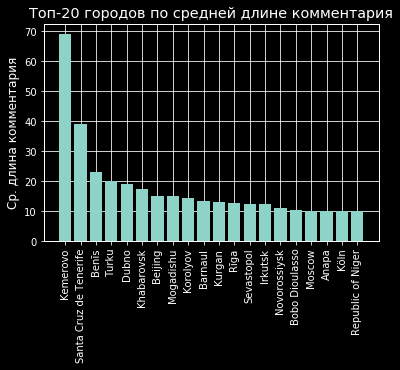

In [192]:
def graph3(posts):
    x, y = comlen_per_city(posts)
    plt.bar(x, y)
    style.use('dark_background')
    gtitle = 'Топ-20 городов по средней длине комментария'
    plt.title(gtitle)
    plt.ylabel('Ср. длина комментария')
    plt.xticks(range(len(x)), [i for i in x], rotation='vertical')
    filename = gtitle + '.png'
    plt.savefig(filename, pad_inches = 5)
    plt.show()
    

graph3(posts)

In [193]:
def len_from_age(posts):
    age_dict = {}
    for key in posts:
        coms = posts[key][3]
        for idc in coms:
            if isinstance(coms[idc][4], int):
                if coms[idc][4] > 0:
                    text = coms[idc][0]
                    com_len = len(text_unlem(text))
                    age = coms[idc][4]
                    if age not in age_dict:
                        age_dict[age] = [com_len]
                    else:
                        age_dict[age].append(com_len)
    na_dict = {}
    for age in age_dict:
        y_cords = age_dict[age]
        if len(y_cords) == 1:
            na_dict[age] = y_cords[0]
        else:
            y_av = round(sum(y_cords) / len(y_cords), 2)
            na_dict[age] = y_av
    x = []
    y = []
    for age in sorted(na_dict):
        x.append(age)
        y.append(na_dict[age])
    return x, y

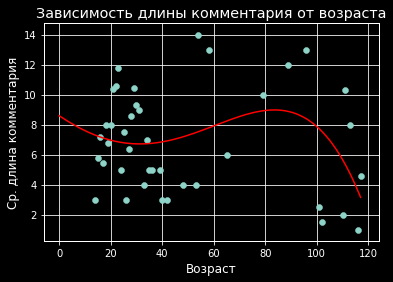

In [194]:
def graph4(posts):
    x, y = len_from_age(posts)
    xl = "Возраст"
    yl = "Ср. длина комментария"
    t = "Зависимость длины комментария от возраста"
    make_graph(x, y, xl, yl, t)

graph4(posts)

In [195]:
def make_text_cloud():
    with open('svtv_unlem.txt', 'r', encoding='utf-16') as f:
        text = f.read()
    text = re.sub('\n', ' ', text)
    t = text.lower()
    words = text_unlem(t)
    with open('stopslov.txt', 'r', encoding='utf-8') as fl:
        stopwords = fl.read()
    stops = stopwords.split()
    for s in stops:
        while s in words:
            words.remove(s)
    w = words
    cloudtext = ' '.join(w)
    return cloudtext

In [196]:
from PIL import Image
from wordcloud import WordCloud

In [197]:
def make_cloud(text):
    mask = np.array(Image.open("fon.jpg"))
    cloud = WordCloud(background_color="white", max_words=200, mask=mask)
    cloud.generate(text)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    cloud.to_file("svtv_cloud.png")

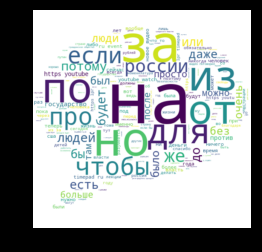

In [198]:
text = make_text_cloud()
make_cloud(text)